## Argo File Loader

In [6]:
# try with newest snapshot
# try with ftp that gmaze used in issue, probably going to be really slow

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import argopy
import scipy.ndimage as filter
import scipy
import matplotlib
import gsw
import traceback
from importlib import reload

import argopy
from argopy import DataFetcher as ArgoDataFetcher

argo_loader = ArgoDataFetcher(
    src="gdac", ftp="/swot/SUM05/dbalwada/Argo_sync", progress=True
)

In [2]:
#print('argopy: {}, xarray: {}, dask: {}'.format(argopy.__version__, xr.__version__, dask.__version__))

In [3]:
import os
os.chdir('/home.ufs/amf2288/argo-intern/funcs')
import density_funcs as df
import EV_funcs as ef
import filt_funcs as ff
import plot_funcs as pf
import processing_funcs as prf
#import argopy_investigation as ai

In [4]:
reload(df)
reload(ef)
reload(ff)
reload(pf)
#reload(mf)
reload(prf)

<module 'processing_funcs' from '/home/amf2288/argo-intern/funcs/processing_funcs.py'>

# Testing Problem Boxes

In [47]:
problem_boxes = [[-5,0,-45,-40,0,2000],
                [-90, -85, -40, -35,0,2000],
                [-120,-115,-35,-30,0,2000],
                [-125,-120,-30,-25,0,2000],
                [-85,-80,-20,-15,0,2000],
                [-90,-85,-20,-15,0,2000],
                [-115,-110,-20,-15,0,2000],
                [-95,-90,-15,-10,0,2000],
                [-105,-100,5,10,0,2000],
                [-95,-90,5,10,0,2000],
                [-105,-100,5,10,0,2000],
                [-115,-110,5,10,0,2000],
                [-130,-125,5,10,0,2000],
                [55,60,-20,-15,0,2000],
                [100,105,-60,-55,0,2000],
                [135,140,-55,-50,0,2000]]

In [48]:
box = problem_boxes[1]
interp_step = 2

ds = argo_loader.region(box)
print("loading points complete")

ds = ds.to_xarray()
print("to xarray complete")

ds = ds.argo.teos10(["CT", "SA", "SIG0"])
ds = ds.argo.point2profile()
print("point to profile complete")

ds_interp = prf.get_ds_interp(ds, box[4], box[5], interp_step)
print("interpolation complete")

ds_interp["SPICE"] = gsw.spiciness0(ds_interp.SA, ds_interp.CT).rename("SPICE")
print("adding spice complete")

ds_interp = prf.get_MLD(ds_interp)
ds_interp = prf.add_times(ds_interp)
print("adding MLD complete")

if 'raw_attrs' in ds_interp.attrs:
    del ds_interp.attrs['raw_attrs']

loading points complete
USING LOCAL ARGOPY DIRECTORY


100%|██████████| 54/54 [03:19<00:00,  3.69s/it]


to xarray complete
point to profile complete
USING THIS DS_INTERP
interpolation complete
adding spice complete
adding MLD complete


In [49]:
non_nan_counts = np.sum(~np.isnan(ds.PRES), axis=1)
non_nan_counts

<xarray.DataArray 'PRES' (N_PROF: 1669)> Size: 13kB
array([  70,   70,   69, ..., 1005, 1005, 1006])
Coordinates:
  * N_PROF     (N_PROF) int64 13kB 85 86 87 88 89 ... 1668 1525 1082 1667 1120
    TIME       (N_PROF) datetime64[ns] 13kB 2005-11-10T07:00:26 ... 2025-02-1...
    LATITUDE   (N_PROF) float64 13kB -38.33 -38.36 -38.35 ... -39.52 -38.83
    LONGITUDE  (N_PROF) float64 13kB -88.92 -88.68 -88.53 ... -87.32 -89.79

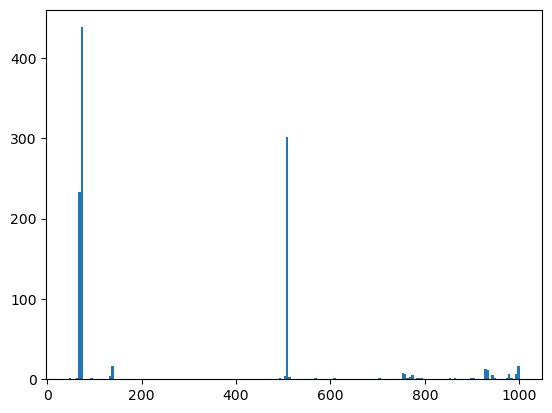

In [50]:
plt.hist(non_nan_counts,bins=np.arange(non_nan_counts.min(),non_nan_counts.max(),5));

In [51]:
print("There are {} profiles in the original dataset".format(len(ds.N_PROF)))
print("There are {} profiles in the interpolated dataset".format(len(ds_interp.N_PROF)))

There are 1669 profiles in the original dataset
There are 820 profiles in the interpolated dataset


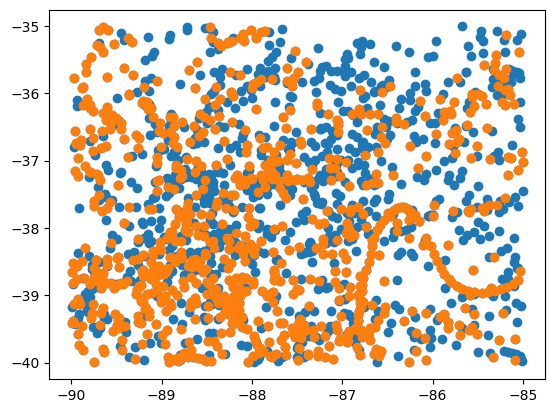

In [52]:
plt.scatter(ds.LONGITUDE, ds.LATITUDE)
plt.scatter(ds_interp.LONGITUDE, ds_interp.LATITUDE)

In [8]:
ds.to_netcdf("/swot/SUM05/amf2288/sync-boxes/globe_load/lon:({},{})_lat:({},{})_ds_z.nc".format(box[0],box[1],box[2],box[3]))

TypeError: Invalid value for attr 'raw_attrs': {'raw_attrs': {'title': 'Argo float vertical profile', 'institution': 'FR GDAC', 'source': 'Argo float', 'history': '2019-04-03T16:03:43Z creation', 'references': 'http://www.argodatamgt.org/Documentation', 'user_manual_version': '3.1', 'Conventions': 'Argo-3.1 CF-1.6', 'featureType': 'trajectoryProfile'}, 'Processing_history': "Transformed with 'profile2point'"}. For serialization to netCDF files, its value must be of one of the following types: str, Number, ndarray, number, list, tuple

## testing parallel loading with dask client

In [ ]:
from dask.distributed import Client

In [ ]:
client= Client(processes=True)

In [ ]:
print(client)

In [ ]:
box = [-27.5, -22.5, -5, 5, 0, 2001]

In [ ]:
%%time
with argopy.set_options(parallel=client):
    f = DataFetcher(src='gdac', ftp='/swot/SUM05/dbalwada/Argo_sync', progress=True).region(box)
    print('%i chunks to process' % len(f.uri))
    print(f)
    ds = f.load().data#.to_xarray()

Okay the process is running on multiple GPUs, in this case 10-12 machines. However, obviously there are a ton of error messages---I'm not really sure what's going wrong. The box I've started with is really small, so I don't think there should be a memory error. Not sure where to go from here.

## Load by box (coordinate: N_PROF)

In [5]:
#box=[lon_min,lon_max,lat_min,lat_max,depth_min,depth_max]
box_atl = [-25,-20,-70,70,0,2001]
box_pac = [-180,-175,-70,70,0,2001]
box_watl = [-60,-55,10,45,0,2001]
box_wpac = [150,155,-5,50,0,2001]
box_wind = [60,65,-65,25,0,2001]

In [6]:
NW = [-180,0,0,90,0,2001]
NE = [0,180,-90,0,0,2001]
SW = [-180,0,-90,0,0,2001]
SE = [0,-180,-90,0,0,2001]

In [7]:
box1 = [-180,-90,  0,90,0,2001]
box2 = [- 90,  0,  0,90,0,2001]
box3 = [   0, 90,  0,90,0,2001]
box4 = [  90,180,  0,90,0,2001]
box5 = [-180,-90,-90, 0,0,2001]
box6 = [- 90,  0,-90, 0,0,2001]
box7 = [   0, 90,-90, 0,0,2001]
box8 = [  90,180,-90, 0,0,2001]

In [8]:
#pf.plot_box([NW,NE,SW,SE])

In [55]:
ds = prf.get_box([-35,-30,-65,-60,0,2000],2)

loading points complete
to xarray complete
point to profile complete
interpolation complete
adding spice complete


In [ ]:
ds = ds.assign_attrs({"Fetched_uri":''})
ds

In [ ]:
ds.to_netcdf("/swot/SUM05/amf2288/sync-boxes/lon:({},{})_lat:({},{})_ds_z.nc".format(NW[0],NW[1],NW[2],NW[3]))

In [ ]:
box_1x = [-10,0,-10,0,0,2000]   #error
box_1y = [-10,0,-20,-10,0,2000] #done
box_1z = [-10,0,-30,-20,0,2000] #done
box_1a = [-10,0,-40,-30,0,2000] #done
box_1b = [-10,0,-50,-40,0,2000] #done
box_1c = [-10,0,-60,-50,0,2000] #done
box_1d = [-10,0,-70,-60,0,2000] #done
box_long=[-10,-8,-70,-10,0,2000]

In [ ]:
pf.plot_box([box_1x,box_1y,box_1z,box_1a,box_1b,box_1c,box_1d,box_long])

In [ ]:
ds_z=ff.get_box(box_long,4)

In [ ]:
ds['N_PROF'].attrs = {'name':'Fetched Profile Number'}
ds['PRES_INTERPOLATED'].attrs = {'name':'Interpolated Pressure', 'units':'dbar', 'notes':'interpolated to standard pressure grid of 2m'}

ds['N_PROF_NEW'].attrs = {'name':'Sequential Profile Number'}
ds['LATITUDE'].attrs = {'name':'Latitude', 'units':'°N'}
ds['LONGITUDE'].attrs = {'name':'Longitude', 'units':'°E'}
ds['month'].attrs = {'name':'Month'}
ds['year'].attrs = {'name':'Year'}
ds['MLD'].attrs = {'name':'Mixed Layer Depth', 'units':'m'}

ds['CT'].attrs = {'name':'Conservative Temperature', 'units':'°C'}
ds['SA'].attrs = {'name':'Absolute Salinity', 'units':'g kg-1'}
ds['SIG0'].attrs = {'name':'Potential Density', 'units':'kg m-1', 'notes':'referenced to 0 dbar'}
ds['SPICE'].attrs = {'name':'Spiciness', 'units':'kg m-1', 'notes':'referenced to 0 dbar'}                  
ds = ds.assign_attrs({"Fetched_uri":''})

In [ ]:
ds_z

In [ ]:
plt.scatter(ds_z.LONGITUDE, ds_z.LATITUDE)

In [ ]:
ds_z.to_netcdf("202206_boxes/lon:({},{})_lat:({},{})_ds_z.nc".format(box_long[0],box_long[1],box_long[2],box_long[3]))

In [ ]:
erddap_loader=ArgoDataFetcher(src'erddap',parallel=True,progress=True)

In [ ]:
gmaze_loader=ArgoDataFetcher(src='gdac',ftp='https://data-argo.ifremer.fr/',parallel=True,progress=True)

In [ ]:
usa_loader=ArgoDataFetcher(src='gdac',ftp='ftp://usgodae.org/pub/outgoing/argo',parallel=True,progress=True)

In [ ]:
ds=argo_loader.region(box_1x)
print('loading points complete')
ds=ds.to_xarray()
print('to xarray complete')

In [ ]:
ds=ds.argo.teos10(['CT','SA','SIG0'])
ds=ds.argo.point2profile()
print('point to profile complete')

In [ ]:
def test_get_box(box,sample_min):
    '''Takes latitude/longitude/depth data and a sample rate and returns an xarray with CT, SA, SIG0, and SPICE interpolated to a pressure grid of 2m. 
    
    box: lat/lon in the form: box=[lon_min, lon_max, lat_min, lat_max, depth_min, depth_max]
    sample_min: minimum sample rate [m]
    '''
    
    ds=argo_loader.region(box)
    print('loading points complete')
    
    ds=ds.to_xarray()
    print('to xarray complete')
    
    ds=ds.argo.teos10(['CT','SA','SIG0'])
    ds=ds.argo.point2profile()
    print('point to profile complete')
    
    ds_interp=get_ds_interp(ds,0,2000,sample_min)
    print('interpolation complete')
    
    ds_interp['SPICE'] = gsw.spiciness0(ds_interp.SA,ds_interp.CT).rename('SPICE')
    print('adding spice complete')
        
    return ds_interp

In [ ]:
test = test_get_box(box_medi,4)

In [ ]:
ds=argo_loader.region(box_medi)

In [ ]:
ds = ds.data

In [ ]:
ds

In [ ]:
ds.PSAL.dropna('N_POINTS')

In [ ]:
for n in range(0,len(ds.N_PROF)):
    

In [ ]:
'''
methods are also functions, but specific to the class they're applied to
class (animals) --> subclass (dogs) --> object (golden retriever)
open_mfdataset() from xarray, for opening data in multiple netcdfs
1) write loop opening all files yourself, check for PSAL, if not there remove file
2) go into open_mfdataset() and see if there's a loop there to exploit instead

locally install repo (pip install -e??)
uses the code from the local repo instead
then make changes to repo: print statement in part of the code we think is happening
then work on loops, etc.


'''

In [ ]:
def to_xarray(self, errors: str = "ignore"):
        """ Load Argo data and return a :class:`xarray.Dataset`

        Parameters
        ----------
        errors: str, default='ignore'
            Define how to handle errors raised during data URIs fetching:

                - 'ignore' (default): Do not stop processing, simply issue a debug message in logging console
                - 'silent':  Do not stop processing and do not issue log message
                - 'raise': Raise any error encountered

        Returns
        -------
        :class:`xarray.Dataset`
        """
        if (
            len(self.uri) > 50
            and isinstance(self.method, str)
            and self.method == "sequential"
        ):
            warnings.warn(
                "Found more than 50 files to load, this may take a while to process sequentially ! "
                "Consider using another data source (eg: 'erddap') or the 'parallel=True' option to improve processing time."
            )
        elif len(self.uri) == 0:
            raise DataNotFound("No data found for: %s" % self.indexfs.cname)

        # Download data:
        ds = self.fs.open_mfdataset(
            self.uri, #list of all float files?
            method=self.method,
            concat_dim="N_POINTS",
            concat=True,
            preprocess=self._preprocess_multiprof,
            progress=self.progress,
            errors=errors,
            open_dataset_opts={'xr_opts': {'decode_cf': 1, 'use_cftime': 0, 'mask_and_scale': 1}},
        )

        # Data post-processing:
        ds["N_POINTS"] = np.arange(
            0, len(ds["N_POINTS"])
        )  # Re-index to avoid duplicate values
        ds = ds.set_coords("N_POINTS")
        ds = ds.sortby("TIME")

        # Remove netcdf file attributes and replace them with simplified argopy ones:
        ds.attrs = {}
        if self.dataset_id == "phy":
            ds.attrs["DATA_ID"] = "ARGO"
        if self.dataset_id == "bgc":
            ds.attrs["DATA_ID"] = "ARGO-BGC"
        ds.attrs["DOI"] = "http://doi.org/10.17882/42182"
        ds.attrs["Fetched_from"] = self.server
        ds.attrs["Fetched_by"] = getpass.getuser()
        ds.attrs["Fetched_date"] = pd.to_datetime("now", utc=True).strftime("%Y/%m/%d")
        ds.attrs["Fetched_constraints"] = self.cname()
        if len(self.uri) == 1:
            ds.attrs["Fetched_uri"] = self.uri[0]
        else:
            ds.attrs["Fetched_uri"] = ";".join(self.uri)

        return ds

In [ ]:
print(ds_z.SIG0.values.min(), ds_z.SIG0.values.max())

In [ ]:
rho_grid = np.linspace(26.6, 28, 1001)

In [ ]:
ds_rho = df.interpolate2density_prof(ds_z, rho_grid)

In [ ]:
ds_rho

In [ ]:
ds_rho.to_netcdf("202206_boxes/lon:({},{})_lat:({},{})_ds_rho.nc".format(box[0],box[1],box[2],box[3]))

## Load by float (coordinate: distance)

In [ ]:
float_ID = 6901265

In [ ]:
ds_z = ff.get_float(float_ID, 4)

In [ ]:
ds_z = ds_z.assign_attrs({"Fetched_uri":''})

In [ ]:
ds_z

In [ ]:
ds_z.to_netcdf("202206_floats/float_ID:({})_ds_z.nc".format(float_ID))

In [ ]:
print(ds_z.SIG0.values.min(), ds_z.SIG0.values.max())

In [ ]:
rho_grid = np.linspace(26.4, 28, 1001)

In [ ]:
ds_rho = df.interpolate2density_prof(ds_z, rho_grid)

In [ ]:
ds_rho

In [ ]:
ds_rho.to_netcdf("202206_floats/float_ID:({})_ds_rho.nc".format(float_ID))

## Loading Boxes by Degree

In [ ]:
lons = np.arange(-180,181,4)
lats = np.arange(-90,91,4)

boxes=[]

for n in range(0,len(lons)-1):
    for m in range(0,len(lats-1)):
        lon_min = lons[n]
        lon_max = lons[n+1]
        lat_min = lats[n]
        lat_max = lats[n+1]
        box_n = np.array([lon_min, lon_max, lat_min, lat_max])
        boxes.append(box_n)

In [ ]:
n=0
lons[n+1]

In [ ]:
from argopy import IndexFetcher as ArgoIndexFetcher

box_bad=[-15,-14,36.5,37]#, '2000-01-01', '2021-06'] # need to remove pressure poinds because the region function for this index fetcher seems a bit different.

idx = ArgoIndexFetcher(src='gdac',dataset='phy',mode='standard',
                            ftp="/swot/SUM05/dbalwada/202203-ArgoData").region(box_bad).load()
idx.index

In [ ]:
float_IDs = [1900041,1900749,]